In [1]:
# setup for work in google colab
from google.colab import drive
drive.mount('/content/drive')

# make this the directory with the python files
import sys
sys.path.append('/content/drive/MyDrive/CPSC452/project')

# !ls /content/drive/MyDrive/CPSC452/project

Mounted at /content/drive


In [2]:
import os
from scipy.io import wavfile
import scipy.signal as signal
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import scipy
import pickle
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [3]:
# ----- python files from the guide/github ----- #
#       make sure these are installed in the same directory as this file and thus importable        #
# https://github.com/KasperGroesLudvigsen/influenza_transformer
# https://towardsdatascience.com/how-to-make-a-pytorch-transformer-for-time-series-forecasting-69e073d4061e

import dataset as ds
import utils
import transformer_timeseries as tst

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Hyperparameters
test_size = 0.1 # proportion of data to use as test data
batch_size = 8 # was 50

## Parameters [many unused in our model] #
dim_val = 512
n_heads = 8 # transformer model
n_decoder_layers = 4
n_encoder_layers = 4

# ----- particular values for our case ----- #
dec_seq_len = 160 # length of input given to decoder
enc_seq_len = 160 # length of input given to encoder
output_sequence_length = 160 # target sequence length (ie. how much you want to generate/output)


window_size = enc_seq_len + output_sequence_length # used to slice data into sub-sequences
step_size = 1 # Step size, i.e. how many time steps does the moving window move at each step
in_features_encoder_linear_layer = 2048
in_features_decoder_linear_layer = 2048
max_seq_len = enc_seq_len
batch_first = False

In [5]:
# ----- load in data set from preprocess.py ----- #
def load_dataset(dataset_name):
    dataset_path = '/content/drive/MyDrive/CPSC452/project/' + dataset_name # change
    with open(dataset_path, 'rb') as f_dataset:
        dataset = pickle.load(f_dataset)
    print(dataset.shape)
    return dataset

data = load_dataset('dataset_wav_10000.pkl')
data = torch.FloatTensor(data).resize(10000, 1, 16000)

clip_dataset = torch.utils.data.TensorDataset(data, data)

train_loader = torch.utils.data.DataLoader(
    clip_dataset,
    batch_size = batch_size,
    shuffle=True
    )


(10000, 16000)


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [6]:
# create model
# input size is the number of variables (degree) being predicted; for us, it's 1 since we want amplitude over time
model = tst.TimeSeriesTransformer(
    input_size=1,
    dec_seq_len=enc_seq_len,
    batch_first=batch_first,
    num_predicted_features=1
    ).to(device)



8000


In [7]:
# ----- training ----- #

learning_rate = 0.0001

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_function = nn.MSELoss()


def train_model(src, tgt, tgt_y, src_mask, tgt_mask):
    """
    Performs a training step on the generator by
        1. running the model to get output
        2. using an MSE loss function comparing generated output to the expected

    Arguments:
        src: source (encoder input)
        tgt: right-shifted target (decoder input) which contains last element of src and data points afterwards
        tgt_y: the target output; compared with generated output for loss
        src_mask, tgt_mask: input masks to prevent transformer from using future data points for prediction

    Returns the loss of this batch
    """
    # zero gradients
    optimizer.zero_grad()

    # passing in the encoder/decoder inputs (with input masks) to the model
    output = model(src, tgt, src_mask, tgt_mask)

    # print(output.shape) # output_sequence_length * batch_size * 1 = 160 * 8 * 1 for us

    # loss with loss function
    loss = loss_function(output, tgt_y)

    # find loss, backpropogate, and step optimizer
    loss.backward()
    optimizer.step()

    # print(loss)

    return loss


In [8]:
epochs = 1 # train longer

mask_amount = 20 # number of data points to mask at the end

for epoch in range(epochs):
    losses = []

    for i, batch in enumerate(train_loader):
        # prep batch stuff manually
        # i: index of batch
        # batch[0] contains the data
        batch = batch[0]

        # preparation of data and inputs to transformer model
        if batch_first:
            batch = batch.permute(0, 2, 1) # 8 * 16000 * 1

            # shift, so that we extract our sample from the middle of the clip
            t = 8000

            # extract transformer inputs src, tgt, tgt_y from data 
            src = batch[:,t:(enc_seq_len+t),:].to(device)
            tgt = batch[:,(enc_seq_len-1+t):(enc_seq_len+dec_seq_len-1+t),:].to(device)
            tgt_y = batch[:,(enc_seq_len+t):(enc_seq_len+output_sequence_length+t),:].to(device)

            # ----- masking of the ends ----- #
            # mask target; treat target as a bunch of zeros; see if can still reconstruct anything similar to tgt_y
            # tgt[:,-mask_amount:,:] = torch.zeros(mask_amount,batch_size,1) # mask_amount

            # normal noise masking
            # tgt[:,-mask_amount:,:] = torch.clamp(torch.normal(mean=torch.zeros(mask_amount,batch_size,1), 
            #                                                   std=torch.zeros(mask_amount,batch_size,1)+0.3), 
            #                                                   min=-1, max=1)

            # create masks, so that transformer decoder doesn't use 'future' data
            src_mask = torch.triu(torch.ones(output_sequence_length, enc_seq_len) * float('-inf'), diagonal=1).to(device)
            tgt_mask = torch.triu(torch.ones(output_sequence_length, enc_seq_len) * float('-inf'), diagonal=1).to(device)

        else:
            batch = batch.permute(2, 0, 1) # 16000 * 8 * 1

            # shift, so that we extract our sample from the middle of the clip
            t = 8000

            # extract transformer inputs src, tgt, tgt_y from data 
            src = batch[t:(enc_seq_len+t),:,:].to(device)
            tgt = batch[(enc_seq_len-1+t):(enc_seq_len+dec_seq_len-1+t),:,:].to(device)
            tgt_y = batch[(enc_seq_len+t):(enc_seq_len+output_sequence_length+t),:,:].to(device)

            # ----- masking of the ends ----- #
            # mask target; treat target as a bunch of zeros; see if can still reconstruct anything similar to tgt_y
            # tgt[-mask_amount:,:,:] = torch.zeros(mask_amount,batch_size,1) # mask_amount

            # normal noise masking
            # tgt[-mask_amount:,:,:] = torch.clamp(torch.normal(mean=torch.zeros(mask_amount,batch_size,1), 
            #                                                   std=torch.zeros(mask_amount,batch_size,1)+0.3), 
            #                                                   min=-1, max=1)

            # create masks, so that transformer decoder doesn't use 'future' data
            src_mask = torch.triu(torch.ones(output_sequence_length, enc_seq_len) * float('-inf'), diagonal=1).to(device)
            tgt_mask = torch.triu(torch.ones(output_sequence_length, enc_seq_len) * float('-inf'), diagonal=1).to(device)


        # pass into train_model()
        loss = train_model(src=src, tgt=tgt, tgt_y = tgt_y, src_mask=src_mask, tgt_mask=tgt_mask).item()

        losses.append(loss)

        if ((i + 1) % 10 == 0 and (epoch + 1) % 1 == 0):
            # print the loss
            print("Training Steps Completed: ", i)
            print(f"Epoch {epoch}: loss: {loss}")

Training Steps Completed:  9
Epoch 0: loss: 0.4252205789089203
Training Steps Completed:  19
Epoch 0: loss: 0.3385706841945648
Training Steps Completed:  29
Epoch 0: loss: 0.13963115215301514
Training Steps Completed:  39
Epoch 0: loss: 0.06994856894016266
Training Steps Completed:  49
Epoch 0: loss: 0.05360233411192894
Training Steps Completed:  59
Epoch 0: loss: 0.06876767426729202
Training Steps Completed:  69
Epoch 0: loss: 0.05804288014769554
Training Steps Completed:  79
Epoch 0: loss: 0.05765325948596001
Training Steps Completed:  89
Epoch 0: loss: 0.08268312364816666
Training Steps Completed:  99
Epoch 0: loss: 0.04936038330197334
Training Steps Completed:  109
Epoch 0: loss: 0.05236463621258736
Training Steps Completed:  119
Epoch 0: loss: 0.04311949759721756
Training Steps Completed:  129
Epoch 0: loss: 0.07948973029851913
Training Steps Completed:  139
Epoch 0: loss: 0.03185088187456131
Training Steps Completed:  149
Epoch 0: loss: 0.022028079256415367
Training Steps Complet

In [6]:
# ----- load in previously trained model ----- #
model_cpu = tst.TimeSeriesTransformer(
    input_size=1,
    dec_seq_len=enc_seq_len,
    batch_first=batch_first,
    num_predicted_features=1
).to(device)
model_cpu.load_state_dict(torch.load('/content/drive/MyDrive/CPSC452/project/test_model_80_40.pt', map_location=device))

8000


<All keys matched successfully>

In [9]:
# ----- extract sample for plotting results! ----- #

mask_amount = 20

for i, batch in enumerate(train_loader):
    # prep batch stuff manually
    # i: index of batch
    # batch[0] contains the data
    batch = batch[0]

    if batch_first:
        batch = batch.permute(0, 2, 1) # 50 * 16000 * 1

        # shift, so that we extract our sample from the middle of the clip
        t = 8000

        # extract transformer inputs src, tgt, tgt_y from data 
        src = batch[:,t:(enc_seq_len+t),:].to(device)
        tgt = batch[:,(enc_seq_len-1+t):(enc_seq_len+dec_seq_len-1+t),:].to(device)
        tgt_y = batch[:,(enc_seq_len+t):(enc_seq_len+output_sequence_length+t),:].to(device)

        # ----- masking of the ends ----- #
        # mask target; treat target as a bunch of zeros; see if can still reconstruct anything similar to tgt_y
        # tgt[:,-mask_amount:,:] = torch.zeros(mask_amount,batch_size,1) # mask_amount

        # normal noise masking
        # tgt[:,-mask_amount:,:] = torch.clamp(torch.normal(mean=torch.zeros(mask_amount,batch_size,1), 
        #                                                   std=torch.zeros(mask_amount,batch_size,1)+0.3), 
        #                                                   min=-1, max=1)

        # create masks, so that transformer decoder doesn't use 'future' data
        src_mask = torch.triu(torch.ones(output_sequence_length, enc_seq_len) * float('-inf'), diagonal=1).to(device)
        tgt_mask = torch.triu(torch.ones(output_sequence_length, enc_seq_len) * float('-inf'), diagonal=1).to(device)

    else:
        batch = batch.permute(2, 0, 1) # 16000 * 50 * 1

        # shift, so that we extract our sample from the middle of the clip
        t = 8000

        # extract data (ran out of memory when trying to use full 16000 data)
        src = batch[t:(enc_seq_len+t),:,:].to(device)
        tgt = batch[(enc_seq_len-1+t):(enc_seq_len+dec_seq_len-1+t),:,:].to(device) # 80 * 50 * 1

        # ----- masking of the ends ----- #
        # mask target; treat target as a bunch of zeros; see if can still reconstruct anything similar to tgt_y
        tgt[-mask_amount:,:,:] = torch.zeros(mask_amount,batch_size,1) # mask_amount

        # normal noise masking
        # tgt[-mask_amount:,:,:] = torch.clamp(torch.normal(mean=torch.zeros(mask_amount,batch_size,1), 
        #                                                   std=torch.zeros(mask_amount,batch_size,1)+0.3), 
        #                                                   min=-1, max=1)

        tgt_y = batch[(enc_seq_len+t):(enc_seq_len+output_sequence_length+t),:,:].to(device)

        # create masks, so that transformer decoder doesn't use 'future' data
        src_mask = torch.triu(torch.ones(output_sequence_length, enc_seq_len) * float('-inf'), diagonal=1).to(device)
        tgt_mask = torch.triu(torch.ones(output_sequence_length, enc_seq_len) * float('-inf'), diagonal=1).to(device)

    break

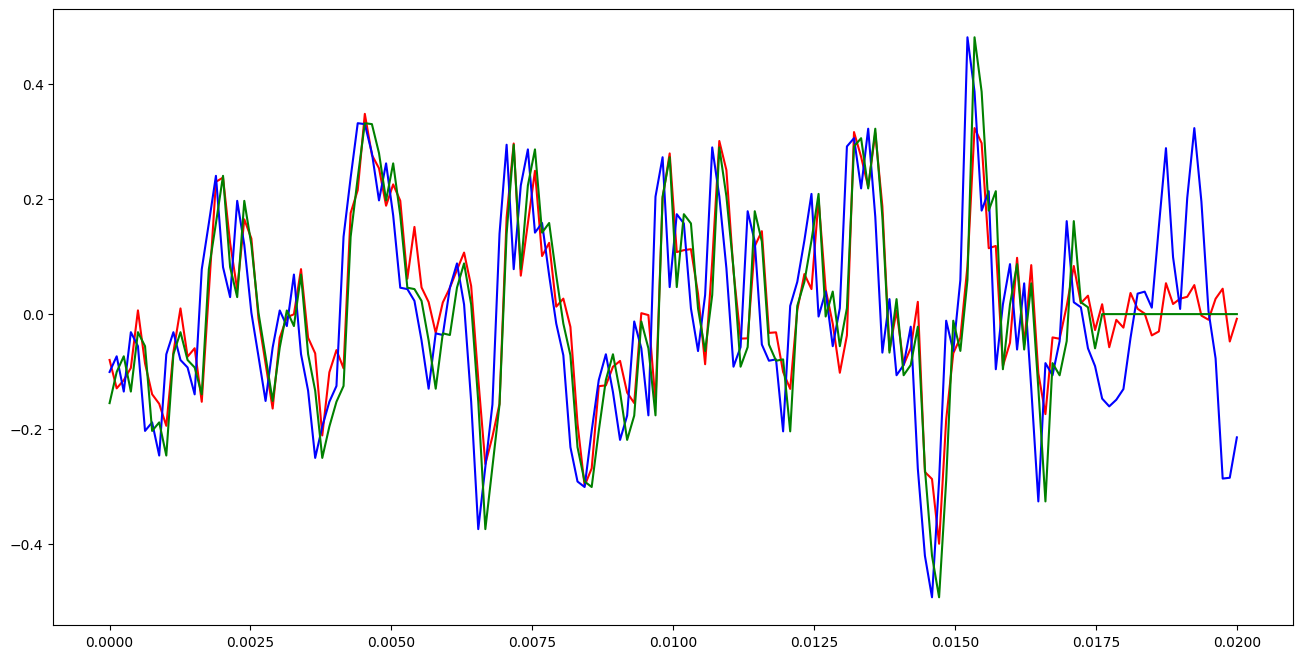

In [11]:
# ----- plotting sample ----- #

# get output for plotting
# output = model_cpu(src=src, tgt=tgt, src_mask=src_mask, tgt_mask=tgt_mask) # loaded in model # 80 * 50 * 1
output = model(src=src, tgt=tgt, src_mask=src_mask, tgt_mask=tgt_mask) # 80 * 50 * 1
# tgt_y # 80 * 50 * 1

def plot_waves(data1, data2, data3, seconds=2, sample_rate=8000):
    
    # check if we have enough data to plot 'seconds' seconds of audio
    assert seconds*sample_rate <= len(data) 
    
    track_y1 = data1[:int(seconds*sample_rate)] # contains generated output
    track_y2 = data2[:int(seconds*sample_rate)] # contains tgt_y
    track_y3 = data3[:int(seconds*sample_rate)] # contains tgt
    track_x = np.linspace(0,seconds,int(seconds*sample_rate))
    
    plt.figure(figsize=(16,8))
    plt.plot(track_x, track_y1, color='r')
    plt.plot(track_x, track_y2, color='b')
    plt.plot(track_x, track_y3, color='g')
    
    
output_plot = torch.squeeze(output[:,1,:]).detach().cpu().numpy()
tgt_y_plot = torch.squeeze(tgt_y[:,1,:]).detach().cpu().numpy()
tgt_plot = torch.squeeze(tgt[:,1,:]).detach().cpu().numpy()

plot_waves(output_plot, tgt_y_plot, tgt_plot, seconds=0.02)